In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

os.chdir(os.path.join(os.getcwd(), '..'))

from data import PollenDataset

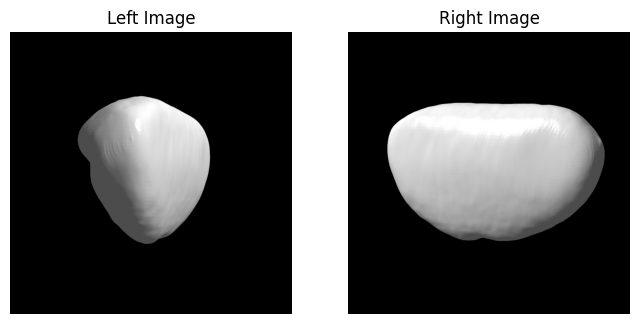

In [2]:
dataset = PollenDataset(image_transforms=transforms.ToTensor())

(left_img, right_img), (vertices, faces) = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [13]:
import pyvista as pv
import os
import sys

pv_mesh = pv.read(os.path.join('data', 'raw', '17767_Common_knapweed_Centaurea_nigra_pollen_grain.stl'))

pv_voxel = pv.voxelize(pv_mesh, density=1)

# turn voxel grid into numpy
voxel_grid = pv_voxel.cell_data_to_point_data().points




pyvista_ndarray([[17.90115023, 13.95558977,  0.285027  ],
                 [18.90115023, 13.95558977,  0.285027  ],
                 [19.90115023, 13.95558977,  0.285027  ],
                 ...,
                 [21.90115023, 24.95558977, 26.285027  ],
                 [22.90115023, 24.95558977, 26.285027  ],
                 [23.90115023, 24.95558977, 26.285027  ]],
                shape=(12761, 3))

In [9]:
# third sqrt of 337272 
np.cbrt(337272)

np.float64(69.6081507167394)

In [52]:
dataset = PollenDataset()
(sample_images, _sample_mesh) = dataset[0]
front_tensor, side_tensor = sample_images  # Assume left = front view, right = side view

# Convert tensors to numpy arrays (images are 1024x1024)
front_np = front_tensor.numpy()
side_np = side_tensor.numpy()

# Create binary masks: any nonzero pixel is considered part of the object.
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define the volume dimensions (cubic volume, size from image dimensions)
H, W = front_bin.shape  # (1024, 1024)
D = W  # depth = width, i.e., 1024

# Extrude the front silhouette along the z-axis.
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis.
# The side view corresponds to (z, y); insert an axis for x and repeat.
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the visual hull as the voxel-wise intersection.
visual_hull = np.logical_and(front_vol, side_vol)

# Downsample the volume for faster visualization if necessary.
# For instance, reduce by a factor of 8 (adjust step as needed).
step = 1
voxel_data = visual_hull[::step, ::step, ::step]

# Plotting the voxels using matplotlib's ax.voxels
#fig = plt.figure(figsize=(8, 8))
#ax = fig.add_subplot(111, projection='3d')

# Plot voxels; you can adjust facecolors, edgecolors, and alpha as desired.
#ax.voxels(voxel_data, facecolors='blue', edgecolor='k', alpha=0.7)

#ax.set_title("Voxel Visualization of Visual Hull")
#ax.set_xlabel("X")
#ax.set_ylabel("Y")
#ax.set_zlabel("Z" )
#plt.show()

### 1. Load sample data and compute the reconstruction (visual hull)

In [53]:
import numpy as np
import trimesh
import torch
from data import PollenDataset

dataset = PollenDataset()
(sample_images, _sample_mesh) = dataset[0]
front_tensor, side_tensor = sample_images  # Assume: left image = front view, right image = side view

# Convert tensors (1024x1024) to numpy arrays
front_np = front_tensor.numpy()
side_np = side_tensor.numpy()

# Create binary masks: any nonzero pixel is considered part of the object.
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define volume dimensions – we assume a cubic volume.
H, W = front_bin.shape  # should be 1024 x 1024
D = W  # depth equal to width

# Extrude the front silhouette along the z-axis:
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis:
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the voxel-wise intersection (Visual Hull):
recon_volume = np.logical_and(front_vol, side_vol)
print("Reconstruction voxel volume shape:", recon_volume.shape)


Reconstruction voxel volume shape: (1024, 1024, 1024)


### 2. Convert the ground truth mesh to a trimesh object and voxelize it

In [54]:
# _sample_mesh is a tuple (vertices, faces) as torch tensors.
vertices, faces = _sample_mesh
vertices = vertices.numpy()
faces = faces.numpy()

# Create a trimesh mesh from the ground truth data.
gt_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# For voxelization, choose a pitch that roughly maps the mesh's bounding box to our grid size.
bbox_min, bbox_max = gt_mesh.bounds
mesh_dims = bbox_max - bbox_min
# Here we choose the pitch so that the largest dimension spans D voxels.
pitch = np.max(mesh_dims) / D
print("Chosen pitch for voxelization:", pitch)

# Voxelize the mesh.
voxelized = gt_mesh.voxelized(pitch)
gt_volume = voxelized.matrix.astype(bool)
print("Ground truth voxel volume shape:", gt_volume.shape)


Chosen pitch for voxelization: 0.02614535763859749
Ground truth voxel volume shape: (677, 1025, 673)


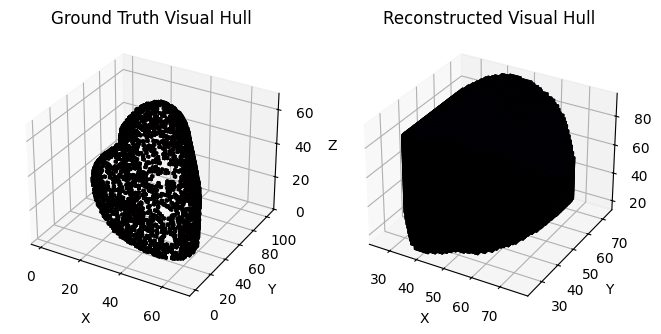

In [56]:
simplification_factor = 10

# Plot the ground truth voxel next to the reconstructed voxel.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(121, projection='3d')
ax.voxels(gt_volume[::simplification_factor, ::simplification_factor, ::simplification_factor], facecolors='red', edgecolor='k', alpha=0.5)
ax.set_title("Ground Truth Visual Hull")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax = fig.add_subplot(122, projection='3d')
ax.voxels(recon_volume[::simplification_factor, ::simplification_factor, ::simplification_factor], facecolors='blue', edgecolor='k', alpha=0.5)
ax.set_title("Reconstructed Visual Hull")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

### 3. Align the voxel grids (if necessary)

In [57]:
# For a direct voxel-wise metric, the occupancy grids need to have the same shape.
# In this example we assume the ground truth is already scaled and aligned.
# If the shapes differ, you might need to pad, crop, or resample one grid to match the other.
if recon_volume.shape != gt_volume.shape:
    print("Warning: The reconstructed and ground truth voxel grids have different shapes.")
    # One simple strategy is to resample the ground truth voxel grid into the reconstruction's shape.
    # Here, for simplicity, we create an empty grid and embed the voxelized ground truth in its center.
    new_gt = np.zeros(recon_volume.shape, dtype=bool)
    gt_shape = np.array(gt_volume.shape)
    recon_shape = np.array(recon_volume.shape)
    # Determine starting indices to center the ground truth grid in the reconstruction grid:
    start = ((recon_shape - gt_shape) // 2).astype(int)
    end = start + gt_shape
    new_gt[start[0]:end[0], start[1]:end[1], start[2]:end[2]] = gt_volume
    gt_volume = new_gt
    print("Resampled ground truth voxel volume shape:", gt_volume.shape)

ValueError: could not broadcast input array from shape (677,1025,673) into shape (677,1,673)

### 4. Compute Metrics: IoU and Dice Coefficient

In [44]:
intersection = np.logical_and(recon_volume, gt_volume).sum()
union = np.logical_or(recon_volume, gt_volume).sum()
iou = intersection / union if union > 0 else 0
dice = 2 * intersection / (recon_volume.sum() + gt_volume.sum()) if (recon_volume.sum() + gt_volume.sum()) > 0 else 0

print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")

ValueError: operands could not be broadcast together with shapes (1024,1024,1024) (677,1025,673) 